In [2]:
from __future__ import print_function, division, absolute_import
# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# set_session(tf.Session(config=config))
# from clr_callback import CyclicLR
# import dill
from BalancedDannAudioDataGenerator import BalancedAudioDataGenerator
import os,time
from scipy.io import loadmat
import numpy as np
np.random.seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import math
import pandas as pd
import tables,h5py
from datetime import datetime
import argparse
from keras.callbacks import TensorBoard, Callback, ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, CSVLogger
from keras import backend as K
from keras.utils import plot_model
from Heartnet import heartnet,getAttentionModel
from utils import log_macc, results_log
from dataLoader import reshape_folds
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import Evaluator
import dataLoader
from custom_layers import Attention
sns.set()
import tensorflow as tf

In [3]:
from keras import losses

In [8]:
yp = np.float32(np.random.rand(10,n))
yp

array([[4.17021990e-01],
       [7.20324516e-01],
       [1.14374816e-04],
       [3.02332580e-01],
       [1.46755889e-01],
       [9.23385918e-02],
       [1.86260208e-01],
       [3.45560730e-01],
       [3.96767467e-01],
       [5.38816750e-01]], dtype=float32)

In [9]:
def printt(x):
    print((tf.Session().run(x)))    

In [ ]:
def Confused_KLD(y_true, y_pred):   ## loss if we asume the output value to be 0.5
    y_predfused = tf.multiply(y_pred,0)+.5     # setting all values of y_pred to 0.5
    return losses.kullback_leibler_divergence(y_predfused,y_true)
    #return losses.kullback_leibler_divergence(y_true,y_predfused)

In [12]:
n = 1 #class number- output unit
#yp = tf.convert_to_tensor(np.float32(np.random.rand(2,n)))          # y_pred randomly generated
yp = tf.convert_to_tensor(np.float32([[.999],[.0011]]))              # y_pred manual value
#yp = tf.convert_to_tensor((np.ones((10,n),dtype=np.float32)*0.4))   
yt = tf.convert_to_tensor( ([[0.0],[0.0]]) )                        # y_true - either 0 or 1

printt(yt)
printt(yp)
#(np.ones((10,n),dtype=np.float32)*0.5),to_categorical([0,1,2,3,4,0,1,2,3,4],n)

[[0.]
 [0.]]
[[0.999 ]
 [0.0011]]


In [13]:
print((tf.Session().run(losses.categorical_crossentropy(yt,yp))))  # original loss 

[0. 0.]


In [27]:
def Confused_Crossentropy(y_true, y_pred):
    y_predfused = tf.multiply(y_pred,0)+.5
    printt(y_true)
    printt(y_pred)
    printt(y_predfused)
    #y_predfused = tf.convert_to_tensor((np.ones((batch,num_class),dtype=np.float32)*0.5))
    #y_truefused = tf.convert_to_tensor( to_categorical(np.ones(batch),num_class) )
    return (K.categorical_crossentropy(y_true, y_pred)), (K.categorical_crossentropy(y_true,y_predfused))

In [79]:
def Confused_MSE(y_true, y_pred):
    y_predfused = tf.multiply(y_pred,0)+.5
    printt(y_true)
    printt(y_pred)
    printt(y_predfused)
    #y_predfused = tf.convert_to_tensor((np.ones((batch,num_class),dtype=np.float32)*0.5))
    #y_truefused = tf.convert_to_tensor( to_categorical(np.ones(batch),num_class) )
    return K.abs(losses.mean_squared_error(y_true, y_pred)-losses.mean_squared_error(y_true,y_predfused))

In [83]:
def Confused_KLD(y_true, y_pred):
    y_predfused = tf.multiply(y_pred,0)+.5
    printt(y_true)
    printt(y_pred)
    printt(y_predfused)
    #y_predfused = tf.convert_to_tensor((np.ones((batch,num_class),dtype=np.float32)*0.5))
    #y_truefused = tf.convert_to_tensor( to_categorical(np.ones(batch),num_class) )
    return losses.kullback_leibler_divergence(y_true,y_predfused)
    #return losses.kullback_leibler_divergence(y_true,y_predfused)

In [52]:
summary_value.ParseFromString(value.encode(encoding='UTF-8',errors='strict'))

/home/mhealthra2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Unexpected end-group tag: Not all data was converted
  """Entry point for launching an IPython kernel.


3

In [50]:
summary_value

simple_value: 5.0

In [25]:
400*49000/1022

19178.08219178082

In [43]:
start_steps = 50 * 253
total_steps = 400 * 253

In [44]:
p = float(50 + start_steps) / total_steps

In [45]:
2. / (1. + np.exp(-10 * p)) - 1

0.5563079001814399

In [20]:
fold_dir = '../../feature/potes_1DCNN/balancedCV/folds/all_folds_wav_name/'
train_domains = 'bcdefghi'
test_domains = 'a'
test_split = 0.0

num_class_domain = len(set(train_domains + test_domains))
num_class = 2

x_train, y_train, y_domain, train_parts,x_val, y_val, val_domain, val_parts, val_wav_files = dataLoader.getData(fold_dir,train_domains,test_domains,test_split)

val_files = val_domain
#Create meta labels and domain labels
domains = train_domains
if(test_split>0):
    domains = domains + test_domains
if(args.dann):
    domains = domains + test_domains
domainClass = [(cls,dfc) for cls in range(2) for dfc in domains]
if(args.dann):
    meta_labels = [domainClass.index((cl,df)) for (cl,df) in zip(np.concatenate((y_train,y_val)),(y_domain+val_domain))]
else:
    meta_labels = [domainClass.index((cl,df)) for (cl,df) in zip(y_train,y_domain)]

y_domain = np.array([list(set(train_domains+test_domains)).index(lab) for lab in y_domain])

val_domain = np.array([list(set(train_domains+test_domains)).index(lab) for lab in val_domain])

Train normal -  13237 - 21627  Abnormal
                37  -  62 %
Test normal -  4303 - 9864  Abnormal
               30  -  69 %


In [21]:
x_train.shape,x_val.shape, y_train.shape, y_val.shape, y_domain.shape,val_domain.shape,len(meta_labels)

((2500, 34864), (2500, 14167), (34864,), (14167,), (34864,), (14167,), 49031)

In [17]:
domains

'bcdefghi'

In [98]:
print("Train  files ", y_train.shape, "  Domain ", y_domain.shape)

Train  files  (49031, 2)   Domain  (49031, 9)


In [101]:
################### Reshaping ############
if(args.dann):
    x_train = np.concatenate((x_train,x_val),axis=1)
    y_domain= np.concatenate((y_domain,val_domain))
[x_train, x_val], [y_train,y_domain,y_val] = reshape_folds([x_train,x_val],[y_train,y_domain,y_val])
y_train = to_categorical(y_train, num_classes=num_class)
if(args.dann):
    y_train = np.concatenate((y_train,np.zeros((y_val.shape[0],2))))
y_domain = to_categorical(y_domain,num_classes=num_class_domain)
y_val = to_categorical(y_val, num_classes=num_class)
val_domain = to_categorical(val_domain,num_classes=num_class_domain)
print("Train  files ", y_train.shape, "  Domain ", y_domain.shape)

reshaped x  (49031, 2500, 1)
reshaped x  (14167, 2500, 1)
reshaped Y  (34864, 1)
reshaped Y  (49031, 1)
reshaped Y  (14167, 1)
Train  files  (49031, 2)   Domain  (49031, 9)


In [10]:
class wow():
    def __init__(self):
        self.dann = True
args = wow()

In [ ]:
reshaped x  (31970, 2500, 1)
reshaped x  (17061, 2500, 1)
reshaped Y  (31970, 1)
reshaped Y  (31970, 1)
reshaped Y  (17061, 1)
Train  files  (31970, 2)   Domain  (31970, 9)

In [22]:
ord('🐸')

128056

In [13]:
ord('g')

103

In [18]:
chr(103)

'g'

In [19]:
chr(128056)

'🐸'

In [14]:
datagen = BalancedAudioDataGenerator(shift=.1)
flow = datagen.flow(x_train, [y_train,y_domain],
                            meta_label=meta_labels,
                            batch_size=1020, shuffle=True,
                            seed=2)

[ 2396   356   308  2860  3012   293  1126  2886   589  1425   493  2852
  1107   288   698 14175]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Chunk size selected as 63


/media/mhealthra2/Data/heart_sound/Adversarial-Heart-Sound-Classification/codes/BalancedDannAudioDataGenerator.py:826: UserWarning: `meta_labels` specified, will use meta_labels instead of target_label
  warnings.warn('`meta_labels` specified, will use meta_labels instead of target_label')


In [42]:
num_filt = (8, 4)
num_dense = 20
lr = 0.01
bn_momentum = 0.99
eps = 1.1e-5
bias = False
l2_reg = 0.04864911065093751
l2_reg_dense = 0.
kernel_size = 5
maxnorm = 10000.
dropout_rate = 0.5
dropout_rate_dense = 0.
padding = 'valid'
activation_function = 'relu'
subsam = 2
FIR_train= True
trainable = True
hp_lambda = np.float32(0)
lr_decay =0.0001132885
random_seed = 1
num_class =2
num_class_domain = 18
tipe= 1
decision = 'majority' 

In [24]:
loadpath='../../Adversarial Heart Sound Results/models/bcdefghi_a 2019-10-16 12:45:03.236037/weights.0036-0.5964.hdf5'
loadatttrain = '../../Adversarial Heart Sound Results/models/attention/bcdefghi_a 2019-10-20 12:37:52.424551/weights.0010-0.5444.hdf5'

In [8]:
os.path.isfile(loadpath)

True

In [31]:
model = heartnet(loadpath,activation_function, bn_momentum, bias, dropout_rate, dropout_rate_dense,
                             eps, kernel_size, l2_reg, l2_reg_dense, lr, lr_decay, maxnorm,
                             padding, random_seed, subsam, num_filt, num_dense, FIR_train, trainable, tipe,
                             num_class=num_class,num_class_domain=9,hp_lambda=hp_lambda)

In [33]:
model = getAttentionModel(model,'bcdefghi_a',lr,lr_decay)

In [28]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2500, 1)      0                                            
__________________________________________________________________________________________________
conv1d_linearphase_type_1 (Conv (None, 2500, 1)      30          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_linearphase_type_2 (Conv (None, 2500, 1)      30          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_linearphase_type_3 (Conv (None, 2500, 1)      30          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_lin

In [32]:
cls = model.get_layer('class_att').get_weights()
dom = model.get_layer('domain_att').get_weights()
clsDense = model.get_layer('class').get_weights()
domDense = model.get_layer('domain').get_weights()

In [29]:
cls2 = model.get_layer('class_att').get_weights()
dom2 = model.get_layer('domain_att').get_weights()
clsDense2 = model.get_layer('class').get_weights()
domDense2 = model.get_layer('domain').get_weights()

In [36]:
max(cls2[0])

1.0

In [26]:
for l in model.layers:
    if('_att' in l.name):
        break
    l.trainable = False
model.get_layer('class_att').trainable = True
model.get_layer('domain_att').trainable = True

In [32]:
len("conv1d_linearphase_type_5")

25

In [33]:
for l in model.layers:
    print(l.name.ljust(30,' '), l.trainable)

input_2                        False
conv1d_linearphase_type_5      False
conv1d_linearphase_type_6      False
conv1d_linearphase_type_7      False
conv1d_linearphase_type_8      False
conv1d_9                       False
conv1d_11                      False
conv1d_13                      False
conv1d_15                      False
batch_normalization_9          False
batch_normalization_11         False
batch_normalization_13         False
batch_normalization_15         False
activation_9                   False
activation_11                  False
activation_13                  False
activation_15                  False
dropout_9                      False
dropout_11                     False
dropout_13                     False
dropout_15                     False
max_pooling1d_9                False
max_pooling1d_11               False
max_pooling1d_13               False
max_pooling1d_15               False
conv1d_10                      False
conv1d_12                      False
c

In [15]:
model.fit_generator(flow,#steps_per_epoch=len(x_train) // batch_size,
                    steps_per_epoch=flow.steps_per_epoch,
                    # max_queue_size=20,
                    use_multiprocessing=False,
                    epochs=200,
                    verbose=1,
                    shuffle=True,
                    callbacks=[log_macc(val_parts, decision=decision,verbose=1,val_files=val_files,wav_files=val_wav_files,checkpoint_name = 'ansari')],
                    validation_data=(x_val, [y_val,val_domain]),
                    initial_epoch=0,
                    )

Check point  ansari
Instructions for updating:
Use tf.cast instead.
Epoch 1/200


ResourceExhaustedError: OOM when allocating tensor of shape [9952,20] and type float
	 [[node training/SGD/zeros_1 (defined at /home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:702) ]]

Caused by op 'training/SGD/zeros_1', defined at:
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-1ce4ce239100>", line 10, in <module>
    initial_epoch=0,
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/keras/engine/training.py", line 1418, in fit_generator
    initial_epoch=initial_epoch)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/keras/engine/training_generator.py", line 40, in fit_generator
    model._make_train_function()
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/keras/engine/training.py", line 509, in _make_train_function
    loss=self.total_loss)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/keras/optimizers.py", line 193, in get_updates
    moments = [K.zeros(shape) for shape in shapes]
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/keras/optimizers.py", line 193, in <listcomp>
    moments = [K.zeros(shape) for shape in shapes]
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py", line 702, in zeros
    v = tf.zeros(shape=shape, dtype=tf_dtype, name=name)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py", line 1817, in zeros
    output = fill(shape, constant(zero, dtype=dtype), name=name)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3367, in fill
    "Fill", dims=dims, value=value, name=name)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [9952,20] and type float
	 [[node training/SGD/zeros_1 (defined at /home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:702) ]]


In [37]:
wow = model.get_layer('att').get_weights()[0]

In [14]:
wow

NameError: name 'wow' is not defined

In [43]:
domainClass = [(cls,dfc) for cls in range(2) for dfc in train_domain]
meta_label = [hey.index((cl,df)) for (cl,df) in zip(y,yd)]

In [44]:
model_json = model.to_json()

TypeError: can't pickle _thread.RLock objects

In [21]:
list(set('sdff'+'cdc'))

['f', 's', 'c', 'd']

In [67]:
hp_lambda = 0.05
epochs = 400
def f_hp_decay(epoch):
    minEpoch = 100
    if hp_lambda == 0:
        return hp_lambda
    #f epoch<minEpoch:
        #eturn np.float32(hp_lambda)
    gamma =  4
    p = (epoch) / (epochs)
    lam =  (2 / (1 + 1*(math.e ** (- gamma * p)))) - 1+.01  # 3 porjonto jaabe
    # hp_lambda = hp_lambda * (params['hp_decay_const'] ** global_epoch_counter)
    return np.float32(lam)

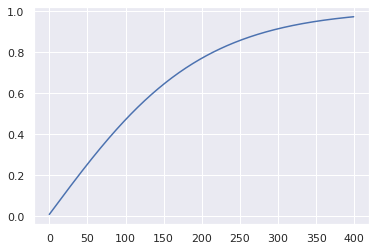

In [68]:
import matplotlib.pyplot as plt
import numpy as np , math
plt.plot([f_hp_decay(e) for e in range(epochs)])

In [58]:
max([f_hp_decay(e) for e in range(epochs)])

0.47113353

In [34]:
def step_decay(epoch):
            
    lr0 = .00128437
    #print("learning rate , lr 0 ", lr, lr0)
    a = 1
    b = 4
    p = epoch/epochs
    lrate = lr0/math.pow((1+a*p),b)
    return lrate

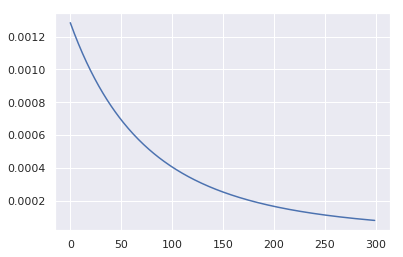

In [35]:
plt.plot([step_decay(e) for e in range(epochs)])

In [96]:
from __future__ import print_function, absolute_import, division
from keras import backend as K
from keras.engine.topology import Layer
from keras.engine.topology import InputSpec
import tensorflow as tf
from keras.utils import conv_utils
from keras.layers import activations, initializers, regularizers, constraints
import numpy as np
from scipy.fftpack import dct
from keras.backend.common import normalize_data_format
from keras.layers.merge import Multiply
class Attt(Layer):
    '''Custom Layer for ResNet used for BatchNormalization.

    Linear learnable weight vector , does dot multiplication on a vector
    # Arguments
        axis: integer, axis along which to normalize in mode 0. For instance,
            if your input tensor has shape (samples, channels, rows, cols),
            set axis to 1 to normalize per feature map (channels axis).'''

    def __init__(self, weights=None, axis=-1,init='he_normal',**kwargs):
        self.axis = axis
        self.init = initializers.get(init)
        self.kernel = weights
        super(Attt, self).__init__(**kwargs)
    def build(self, input_shape):
        if len(input_shape)>2:
            raise ValueError("Input to attention layer hasn't been flattened")
        self.input_dim = input_shape[-1]            
        self.kernel = self.add_weight(shape=(self.input_dim,),
                                      initializer=initializers.Ones(),
                                      name='kernel',
                                      constraint=constraints.NonNeg()
                                      #constraint=constraints.min_max_norm(min_value=0.0, max_value=1.0)
                                      #constraint=constraints.UnitNorm(axis=self.axis)
                                     )
        self.input_spec = InputSpec(min_ndim=2, axes={-1: self.input_dim})            
        self.built = True
    def call(self, inputs):
        output = tf.multiply(inputs,self.kernel)
        return output
    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = {
            'axis': self.axis,
            'kernel_initializer': initializers.serialize(self.init)
        }
        base_config = super(Attt, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [98]:
from keras.layers import Input, Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Activation, AveragePooling1D